In [1]:
!pip install wandb
!pip install keras_cv

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import keras_cv
import wandb
import os

from datetime import datetime
from google.colab.patches import cv2_imshow
from wandb.keras import WandbMetricsLogger

Using TensorFlow backend


## Define Hyperparameters

In [3]:
wandb.login()

wandb: Currently logged in as: kristopher-nolte (convector). Use `wandb login --relogin` to force relogin


True

In [4]:
# 3 Rings for the Elven-kings under the sky,
# 7 for the Dwarf-lords in their halls of stone,
# 9 for Mortal Men, doomed to die,
# 1 for the Dark Lord on his dark throne
SEED = 3
DEPICTION = "body"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

species_list = ['AE', 'AL', 'JA', 'KO']

# on colab
DIR_PATH = "/content/drive/MyDrive/PhD/WingDatabase/DeviceDataset/{}".format(DEPICTION)
SAVE_DIR = "/content/drive/MyDrive/PhD/WingComparisonStudy/models_device"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
IMG_SIZE = 300
BATCH_SIZE = 16
LEARNING_RATE_TRANSFER = 5e-4
MAX_EPOCHS_TRANSFER = 24
EARLY_STOP_PATIENCE = 12
STEPS_PER_EPOCH = 81
DROPOUT = 0.5

AUG_LAYER = 3
AUG_MAGNITUDE = .05
AUG_ROTATTION = .05
AUG_TRANSLATION = .05
AUG_SHARPNESS = .25
AUG_COLORDEGEN = .25
AUG_NOISE = .1

## Load Dataset

In [7]:
def create_dict(data_split):
    #get a list of image paths defined by the target list
    image_path_dict = {}

    for species in species_list:
        path = DIR_PATH + "/{}/{}/*.png".format(data_split, species)
        image_path_dict[species] = tf.data.Dataset.list_files(path,  shuffle=True, seed=SEED)

    return image_path_dict

def combine_dict(dataset_dict):
  #combine all target_dicts together
  for i,key in enumerate(dataset_dict.keys()):
    if i == 0:
        image_path_ds = dataset_dict[key]
    else:
        image_path_ds = image_path_ds.concatenate(dataset_dict[key])

  return image_path_ds.shuffle(buffer_size=image_path_ds.cardinality())

#create dicts with species as key and tf.ShuffleDataset containing paths as values
if DEPICTION == "body":
  train_phone_path_dict = create_dict("train/phone")
train_macro_path_dict = create_dict("train/macro")
train_micro_path_dict = create_dict("train/micro")

val_path_dict = create_dict("val")
test_path_dict = create_dict("test")

#combine dicts to Tensorflow dataset
if DEPICTION == "body":
  trainDS_phone_filelist = combine_dict(train_phone_path_dict)
trainDS_macro_filelist = combine_dict(train_macro_path_dict)
trainDS_micro_filelist = combine_dict(train_micro_path_dict)

valDS_filelist = combine_dict(val_path_dict)
testDS_filelist = combine_dict(test_path_dict)

In [8]:
trainDS_micro_filelist.__len__()

<tf.Tensor: shape=(), dtype=int64, numpy=557>

In [9]:
def getLabel_onehot(file_path):
    # Convert the path to a list of path components
    speciesName = tf.strings.split(file_path, os.path.sep)[-2]
    # get one_hot vector boolean
    species_one_hot = speciesName == species_list
    # cast vector type to integer
    species_one_hot = tf.cast(species_one_hot, dtype=tf.int8, name=None)
    return species_one_hot

def getImage(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, dtype=tf.float32)
    return img

def process_path(file_path):
    species_label = getLabel_onehot(file_path)
    img = getImage(file_path)

    return img, species_label

if DEPICTION == "body":
  trainDSphone_raw = trainDS_phone_filelist.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
trainDSmacro_raw = trainDS_macro_filelist.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
trainDSmicro_raw = trainDS_micro_filelist.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

valDS_raw = valDS_filelist.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
testDS_raw = testDS_filelist.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

## Initialise Augmentation

In [10]:
randAugment = keras_cv.layers.RandAugment(value_range=(0, 255),
                                           augmentations_per_image=AUG_LAYER,
                                           magnitude=AUG_MAGNITUDE,
                                           geometric=False,
                                           rate=1,
                                           seed=SEED)

#Allowed Geometric Augmentations
randRot = tf.keras.layers.RandomRotation(AUG_ROTATTION, seed=SEED)
randFlip = tf.keras.layers.RandomFlip(mode="horizontal", seed=SEED)
randTrans = tf.keras.layers.RandomTranslation(AUG_TRANSLATION, AUG_TRANSLATION, fill_mode="constant", seed=SEED)

#Colorchanging Augmentations
randSharp = keras_cv.layers.RandomSharpness(AUG_SHARPNESS, value_range=(0, 255), seed=SEED)
randColorDegen = keras_cv.layers.RandomColorDegeneration(AUG_COLORDEGEN, seed=SEED)
randNoise = tf.keras.layers.GaussianNoise(AUG_NOISE)

def augment(img, label):
  img = randRot(img)
  img = randTrans(img)
  img = randFlip(img)
  img = randColorDegen(img)
  img = randAugment(img)
  img = randSharp(img)
  img = randNoise(img)
  return img, label

if DEPICTION == "body":
  trainDSphone = trainDSphone_raw.map(augment, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
trainDSmacro = trainDSmacro_raw.map(augment, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
trainDSmicro = trainDSmicro_raw.map(augment, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

valDS = valDS_raw.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
testDS = testDS_raw.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

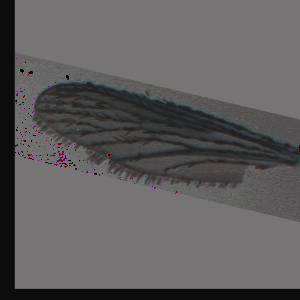

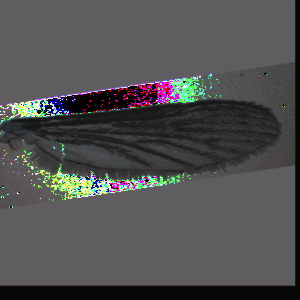

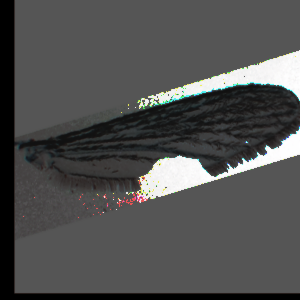

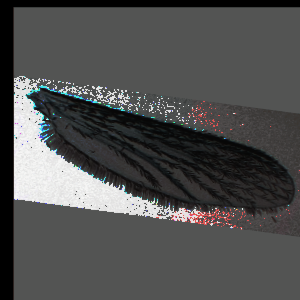

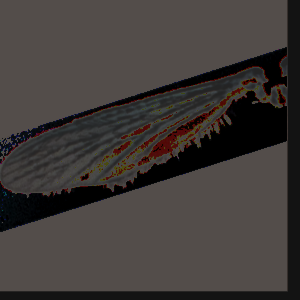

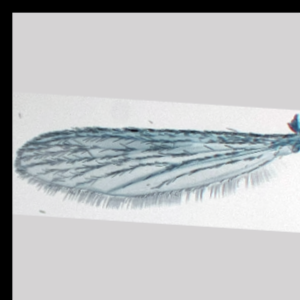

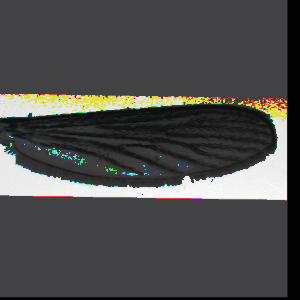

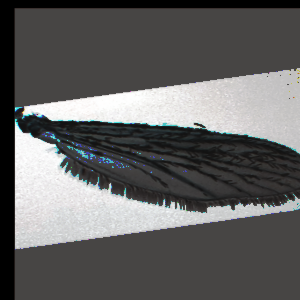

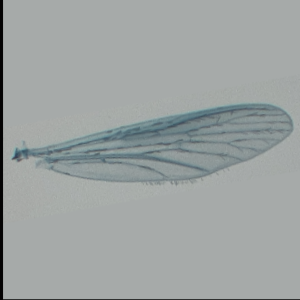

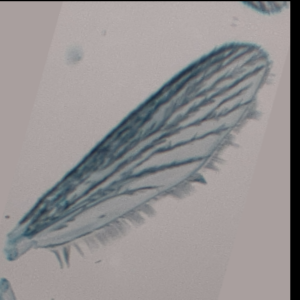

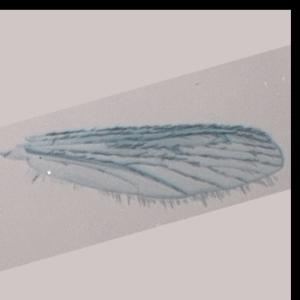

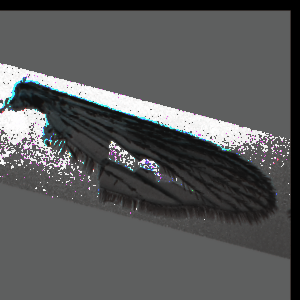

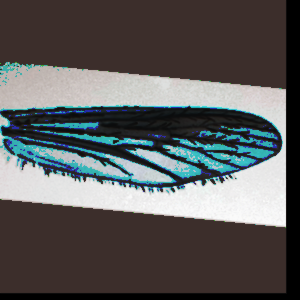

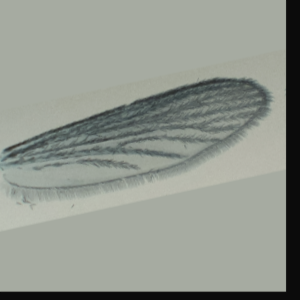

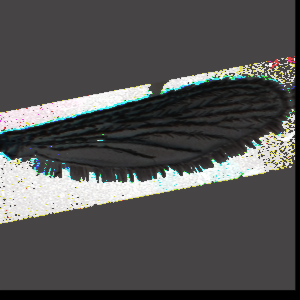

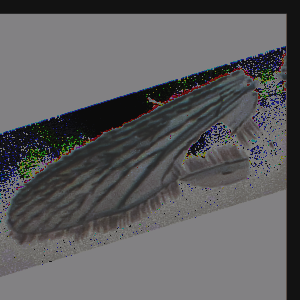

In [11]:
batch = next(iter(trainDSmacro))
for i in range(BATCH_SIZE):
  cv2_imshow(batch[0][i].numpy())

## Initialise Models

In [12]:
def build_model(BASE_MODEL, input_size):
    BASE_MODEL.trainable = False

    #Fully Connected Segment
    flatten_layer = tf.keras.layers.GlobalAveragePooling2D()(BASE_MODEL.output)
    regu_layer = tf.keras.layers.Dropout(DROPOUT)(flatten_layer)
    output_layer = tf.keras.layers.Dense(4, activation = "softmax")(regu_layer)

    #Built Model
    model = tf.keras.Model(inputs=BASE_MODEL.inputs, outputs=output_layer)

    return model

model_dict = {}
if DEPICTION == "body":
    model_dict["phone"]  = build_model(tf.keras.applications.EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3), include_preprocessing=True), IMG_SIZE)
model_dict["macro"]  = build_model(tf.keras.applications.EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3), include_preprocessing=True), IMG_SIZE)
model_dict["micro"]  = build_model(tf.keras.applications.EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3), include_preprocessing=True), IMG_SIZE)

## Transfer Learning

In [13]:
LOSS = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
OPTIMIZER_TRANSFER = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE_TRANSFER)
EARLY_STOP = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = EARLY_STOP_PATIENCE, mode='auto', restore_best_weights=False)

for model in model_dict:
  wandb.finish()
  model_run = "_".join([model, DEPICTION, str(SEED), datetime.now().strftime('%Y-%m-%d-%H-%M')])
  # Inititiliaze weights&biases
  wandb.init(name=model_run,
             project="comparison_device",

      # track hyperparameters and run metadata with wandb.config
      config={
          "Model Name": model,
          "Depiction": DEPICTION,
          "Batch Size": BATCH_SIZE,
          "Epochs": MAX_EPOCHS_TRANSFER,
          "Learning Rate": LEARNING_RATE_TRANSFER})

  MONITOR_CALLBACK =  wandb.keras.WandbCallback(save_model=False)

  if "macro" in model:
      trainDS = trainDSmacro
  elif "micro" in model:
      trainDS = trainDSmicro
  elif "phone" in model and DEPICTION == "body":
      trainDS = trainDSphone

  model_dict[model].compile(optimizer=OPTIMIZER_TRANSFER, loss=LOSS, metrics=["accuracy"])
  history = model_dict[model].fit(trainDS, epochs=MAX_EPOCHS_TRANSFER, validation_data=valDS, callbacks=[EARLY_STOP, MONITOR_CALLBACK])
  model_dict[model].save(os.path.join(SAVE_DIR, model_run+".h5"))

Epoch 1/24
35/35 [==============================] - 17s 190ms/step - loss: 1.4464 - accuracy: 0.2878 - val_loss: 1.2450 - val_accuracy: 0.5397
Epoch 2/24
35/35 [==============================] - 1s 26ms/step - loss: 1.2531 - accuracy: 0.4263 - val_loss: 1.1321 - val_accuracy: 0.5900
Epoch 3/24
35/35 [==============================] - 1s 26ms/step - loss: 1.1206 - accuracy: 0.5432 - val_loss: 1.0662 - val_accuracy: 0.6234
Epoch 4/24
35/35 [==============================] - 1s 26ms/step - loss: 1.0375 - accuracy: 0.5899 - val_loss: 0.9997 - val_accuracy: 0.6276
Epoch 5/24
35/35 [==============================] - 1s 26ms/step - loss: 0.9680 - accuracy: 0.6259 - val_loss: 0.9569 - val_accuracy: 0.6485
Epoch 6/24
35/35 [==============================] - 1s 26ms/step - loss: 0.9307 - accuracy: 0.6655 - val_loss: 0.9350 - val_accuracy: 0.6695
Epoch 7/24
35/35 [==============================] - 1s 26ms/step - loss: 0.8620 - accuracy: 0.6601 - val_loss: 0.9057 - val_accuracy: 0.6736
Epoch 8/24


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██████
epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▅▆▆▆▆▇▆▇▇▇▇▇█████▇██
val_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,0.78597
best_epoch,22
best_val_loss,0.74947
epoch,23
loss,0.59343
val_accuracy,0.71548


Epoch 1/24
35/35 [==============================] - 13s 160ms/step - loss: 1.3220 - accuracy: 0.3950 - val_loss: 0.9700 - val_accuracy: 0.6318
Epoch 2/24
35/35 [==============================] - 1s 26ms/step - loss: 0.9091 - accuracy: 0.6248 - val_loss: 0.8886 - val_accuracy: 0.6485
Epoch 3/24
35/35 [==============================] - 1s 26ms/step - loss: 0.8250 - accuracy: 0.6786 - val_loss: 0.8288 - val_accuracy: 0.6736
Epoch 4/24
35/35 [==============================] - 1s 26ms/step - loss: 0.7737 - accuracy: 0.7289 - val_loss: 0.8247 - val_accuracy: 0.6695
Epoch 5/24
35/35 [==============================] - 1s 26ms/step - loss: 0.7615 - accuracy: 0.7110 - val_loss: 0.7694 - val_accuracy: 0.7155
Epoch 6/24
35/35 [==============================] - 1s 26ms/step - loss: 0.6874 - accuracy: 0.7397 - val_loss: 0.7373 - val_accuracy: 0.7197
Epoch 7/24
35/35 [==============================] - 1s 26ms/step - loss: 0.6922 - accuracy: 0.7289 - val_loss: 0.6990 - val_accuracy: 0.7448
Epoch 8/24


In [14]:
def get_cnn_prediction(cnn_model, dataset):
    # Let model predict
    prediction_list = cnn_model.predict(dataset, verbose=0)

    def parse_prediction(prediction_list, rank):
        highest_score_list = [np.sort(prediction)[-rank] for prediction in prediction_list]
        highest_score_index_list = [np.where(prediction_list[i] == highest_score)[0][0] for i, highest_score in enumerate(highest_score_list)]
        species_name_list = [species_list[highest_score_index] for highest_score_index in highest_score_index_list]

        return np.asarray(highest_score_list), np.asarray(species_name_list)

    highest_score_list, species_name_list = parse_prediction(prediction_list, 1)
    sec_highest_score_list, sec_species_name_list = parse_prediction(prediction_list, 2)

    return highest_score_list, species_name_list, sec_highest_score_list, sec_species_name_list, prediction_list

def get_system_prediction(cnn_model, designation, species_list):
    # Load Images
    df_temp = pd.DataFrame(columns=["image_path", "pred_label", "highest_score", "sec_pred_label", "sec_highest_score", "datasplit", "true_label"])
    for species in species_list:
        try:
            folder_path = os.path.join(DIR_PATH, designation, species, "*.png")
            file_list = tf.data.Dataset.list_files(folder_path, shuffle=False)
            dataset = file_list.map(getImage).batch(1)

            # Get Predictions
            highest_score_list, species_name_list, sec_highest_score_list, sec_species_name_list, prediction_list = get_cnn_prediction(cnn_model, dataset)

            df = pd.DataFrame({"image_path": [f.numpy().decode('utf-8') for f in file_list],
                           "pred_label": species_name_list,
                           "highest_score": highest_score_list,
                           "sec_pred_label": sec_species_name_list,
                           "sec_highest_score": sec_highest_score_list,
                               "datasplit": [designation]*file_list.__len__().numpy(),
                               "true_label": [species]*file_list.__len__().numpy(),})

            df_temp = pd.concat([df_temp, df])

        except Exception as e: print(species , e)
    return df_temp

df_dict = {}
for model in model_dict.keys():
    model_run = "_".join([model, DEPICTION, str(SEED), datetime.now().strftime('%Y-%m-%d-%H-%M')])
    df_val = get_system_prediction(model_dict[model], "val", species_list)
    df_test = get_system_prediction(model_dict[model], "test", species_list)
    df_dict[model] = pd.concat([df_val, df_test])

    df_dict[model]["correct"] = df_dict[model]["pred_label"] == df_dict[model]["true_label"]
    df_dict[model].to_pickle(os.path.join(SAVE_DIR, model_run + "_VALTEST.pkl"))